IT19113296

##  Feature Selection

In [111]:
num_feats=11

def cor_selector(X, y,num_feats):
    cor_list = []
    feature_name = X.columns.tolist()
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature
cor_support, cor_feature = cor_selector(X, y,num_feats)
print(str(len(cor_feature)), 'selected features')

11 selected features


In [112]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=num_feats)
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()
print(str(len(chi_feature)), 'selected features')

11 selected features


In [113]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=num_feats, step=10, verbose=5)
rfe_selector.fit(X_norm, y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')

Fitting estimator with 15 features.
11 selected features


In [114]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l2", solver='lbfgs'), max_features=num_feats)
embeded_lr_selector.fit(X_norm, y)

embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = X.loc[:,embeded_lr_support].columns.tolist()
print(str(len(embeded_lr_feature)), 'selected features')

7 selected features


In [115]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100, criterion='gini'), max_features=num_feats)
embeded_rf_selector.fit(X, y)

embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
print(str(len(embeded_rf_feature)), 'selected features')

8 selected features


In [119]:
from sklearn.feature_selection import SelectFromModel
!pip install lightgbm
from lightgbm import LGBMClassifier

lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
            reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

embeded_lgb_selector = SelectFromModel(lgbc, max_features=num_feats)
embeded_lgb_selector.fit(X, y)

embeded_lgb_support = embeded_lgb_selector.get_support()
embeded_lgb_feature = X.loc[:,embeded_lgb_support].columns.tolist()
print(str(len(embeded_lgb_feature)), 'selected features')

6 selected features


In [120]:
# put all selection together
feature_name = X.columns
feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'Chi-2':chi_support, 'RFE':rfe_support, 'Logistics':embeded_lr_support,
                                    'Random Forest':embeded_rf_support, 'LightGBM':embeded_lgb_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)
feature_selection_df.head(num_feats)

,Feature,Pearson,Chi-2,RFE,Logistics,Random Forest,LightGBM,Total
1,st_depression,True,True,True,True,True,True,6
2,st_slope_flat,True,True,True,True,True,False,5
3,max_heart_rate_achieved,True,True,True,False,True,True,5
4,exercise_induced_angina,True,True,True,False,True,True,5
5,cholesterol,True,False,True,True,True,True,5
6,age,True,True,True,False,True,True,5
7,st_slope_upsloping,True,True,True,False,True,False,4
8,sex_male,True,True,True,True,False,False,4
9,chest_pain_type_non-anginal pain,True,True,True,True,False,False,4
10,chest_pain_type_atypical angina,True,True,True,True,False,False,4


In [121]:
# segregating dataset into features i.e., X and target variables i.e., y
X = dt.drop(['target','resting_blood_pressure','sex_male','chest_pain_type_non-anginal pain','chest_pain_type_atypical angina'],axis=1)
y = dt['target']

In [122]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2,shuffle=True, random_state=5)

In [123]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train[['age','cholesterol','max_heart_rate_achieved','st_depression']] = scaler.fit_transform(X_train[['age','cholesterol','max_heart_rate_achieved','st_depression']])
X_train.head()

,age,cholesterol,fasting_blood_sugar,max_heart_rate_achieved,exercise_induced_angina,st_depression,chest_pain_type_typical angina,rest_ecg_left ventricular hypertrophy,rest_ecg_normal,st_slope_flat,st_slope_upsloping
478,0.673469,0.000000,1,0.303704,1,0.454545,0,0,1,0,0
253,0.673469,0.594705,0,0.355556,1,0.194805,0,0,0,0,1
273,0.551020,0.409369,0,0.466667,1,0.584416,0,0,1,1,0
111,0.591837,0.519348,0,0.185185,1,0.584416,0,0,1,1,0
50,0.448980,0.474542,0,0.400000,1,0.454545,0,0,1,1,0


In [124]:
X_test[['age','cholesterol','max_heart_rate_achieved','st_depression']] = scaler.transform(X_test[['age','cholesterol','max_heart_rate_achieved','st_depression']])
X_test.head()

,age,cholesterol,fasting_blood_sugar,max_heart_rate_achieved,exercise_induced_angina,st_depression,chest_pain_type_typical angina,rest_ecg_left ventricular hypertrophy,rest_ecg_normal,st_slope_flat,st_slope_upsloping
1024,0.693878,0.572301,0,0.266667,0,0.376623,0,1,0,1,0
182,0.469388,0.456212,0,0.614815,0,0.194805,0,0,1,0,1
785,0.346939,0.480652,0,0.629630,1,0.220779,0,1,0,1,0
924,0.591837,0.562118,0,0.333333,1,0.272727,0,1,0,1,0
780,0.612245,0.527495,0,0.466667,1,0.584416,0,1,0,1,0


In [125]:
import xgboost as xgb
models = GetBasedModel()
names,results = BasedLine2(X_train, y_train,models)

LR_L2: 0.819515 (0.049077)
LDA: 0.819526 (0.045906)
KNN7: 0.812171 (0.030595)
KNN5: 0.804610 (0.043972)
KNN9: 0.808900 (0.030790)
KNN11: 0.810970 (0.039220)
CART: 0.855834 (0.035975)
NB: 0.823782 (0.047121)
SVM Linear: 0.812022 (0.047971)
SVM RBF: 0.805662 (0.040935)
AB: 0.814139 (0.049168)
GBM: 0.851533 (0.037925)
RF_Ent100: 0.916701 (0.027641)
RF_Gini100: 0.920968 (0.030187)
ET100: 0.921002 (0.026836)
ET500: 0.919904 (0.027785)
MLP: 0.837692 (0.041139)
SGD3000: 0.809963 (0.038354)
XGB_2000: 0.900709 (0.027723)
XGB_500: 0.906051 (0.029528)
XGB_100: 0.909243 (0.027330)
XGB_1000: 0.904976 (0.027442)
ET1000: 0.919927 (0.025548)


## Soft voting

In [126]:
import xgboost as xgb
clf1=RandomForestClassifier(criterion='entropy',n_estimators=100)

clf2=DecisionTreeClassifier()
clf3=xgb.XGBClassifier(n_estimators= 1000)
clf4=ExtraTreesClassifier(n_estimators= 500)

clf5=GradientBoostingClassifier(n_estimators=100,max_features='sqrt')


eclf1 = VotingClassifier(estimators=[('rfe', clf1), ('decc', clf2), ('xgb', clf3),('ET',clf4),('gb',clf5),], 
                         voting='soft', weights=[4,1,2,3,1])
eclf1.fit(X_train,y_train)
y_pred_sv =eclf1.predict(X_test)

## Model Evaluation

,Model,Accuracy,Precision,Sensitivity,Specificity,F1 Score,ROC,Log_Loss,mathew_corrcoef
0,Soft Voting,0.893617,0.871212,0.934959,0.848214,0.901961,0.891587,3.674396,0.788341


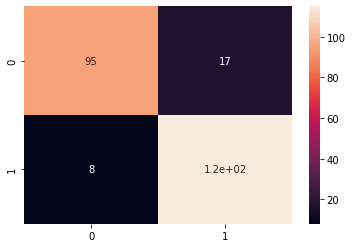

In [127]:
CM=confusion_matrix(y_test,y_pred_sv)
sns.heatmap(CM, annot=True)

TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
specificity = TN/(TN+FP)
loss_log = log_loss(y_test, y_pred_sv)
acc= accuracy_score(y_test, y_pred_sv)
roc=roc_auc_score(y_test, y_pred_sv)
prec = precision_score(y_test, y_pred_sv)
rec = recall_score(y_test, y_pred_sv)
f1 = f1_score(y_test, y_pred_sv)

mathew = matthews_corrcoef(y_test, y_pred_sv)
model_results =pd.DataFrame([['Soft Voting',acc, prec,rec,specificity, f1,roc, loss_log,mathew]],
               columns = ['Model', 'Accuracy','Precision', 'Sensitivity','Specificity', 'F1 Score','ROC','Log_Loss','mathew_corrcoef'])

model_results

In [128]:
rf_ent = RandomForestClassifier(criterion='entropy',n_estimators=100)
rf_ent.fit(X_train, y_train)
y_pred_rfe = rf_ent.predict(X_test)

In [129]:
mlp = MLPClassifier()
mlp.fit(X_train,y_train)
y_pred_mlp = mlp.predict(X_test)

In [130]:
knn = KNeighborsClassifier(9)
knn.fit(X_train,y_train)
y_pred_knn = knn.predict(X_test)

In [131]:
svc = SVC(kernel='linear',gamma='auto',probability=True)
svc.fit(X_train,y_train)
y_pred_svc = svc.predict(X_test)

In [132]:
data = {
             'Random Forest Entropy': y_pred_rfe, 
                'MLP2': y_pred_mlp, 
                'KNN2': y_pred_knn,
                'SVC2': y_pred_svc}

models = pd.DataFrame(data) 
 
for column in models:
    CM=confusion_matrix(y_test,models[column])
    
    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    specificity = TN/(TN+FP)
    loss_log = log_loss(y_test, models[column])
    acc= accuracy_score(y_test, models[column])
    roc=roc_auc_score(y_test, models[column])
    prec = precision_score(y_test, models[column])
    rec = recall_score(y_test, models[column])
    f1 = f1_score(y_test, models[column])
    
    mathew = matthews_corrcoef(y_test, models[column])
    results =pd.DataFrame([[column,acc, prec,rec,specificity, f1,roc, loss_log,mathew]],
               columns = ['Model', 'Accuracy','Precision', 'Sensitivity','Specificity', 'F1 Score','ROC','Log_Loss','mathew_corrcoef'])
    model_results = model_results.append(results, ignore_index = True)

model_results

,Model,Accuracy,Precision,Sensitivity,Specificity,F1 Score,ROC,Log_Loss,mathew_corrcoef
0,Soft Voting,0.893617,0.871212,0.934959,0.848214,0.901961,0.891587,3.674396,0.788341
1,Random Forest Entropy,0.897872,0.877863,0.934959,0.857143,0.905512,0.896051,3.527419,0.796509
2,MLP2,0.821277,0.813953,0.853659,0.785714,0.833333,0.819686,6.172969,0.641753
3,KNN2,0.812766,0.806202,0.845528,0.776786,0.825397,0.811157,6.466920,0.624631
4,SVC2,0.808511,0.778571,0.886179,0.723214,0.828897,0.804697,6.613914,0.620202


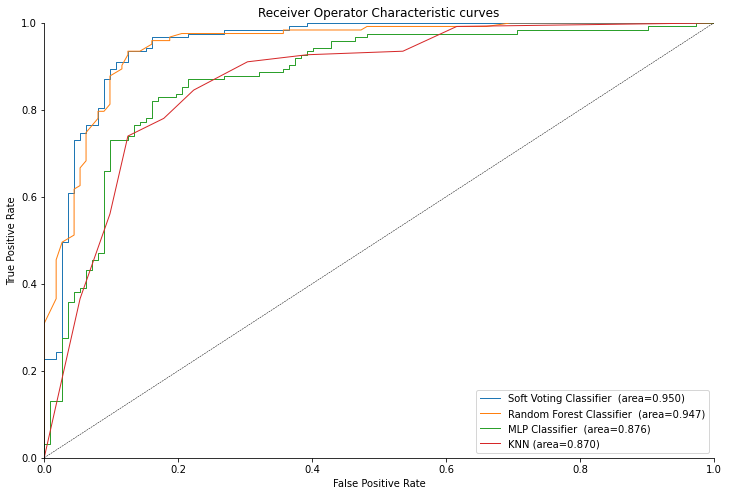

In [134]:
def roc_auc_plot(y_true, y_proba, label=' ', l='-', lw=1.0):
    from sklearn.metrics import roc_curve, roc_auc_score
    fpr, tpr, _ = roc_curve(y_true, y_proba[:,1])
    ax.plot(fpr, tpr, linestyle=l, linewidth=lw,
            label="%s (area=%.3f)"%(label,roc_auc_score(y_true, y_proba[:,1])))

f, ax = plt.subplots(figsize=(12,8))

roc_auc_plot(y_test,eclf1.predict_proba(X_test),label='Soft Voting Classifier ',l='-')
roc_auc_plot(y_test,rf_ent.predict_proba(X_test),label='Random Forest Classifier ',l='-')
roc_auc_plot(y_test,mlp.predict_proba(X_test),label='MLP Classifier ',l='-')
roc_auc_plot(y_test,knn.predict_proba(X_test),label='KNN',l='-')

ax.plot([0,1], [0,1], color='k', linewidth=0.5, linestyle='--', 
        )    
ax.legend(loc="lower right")    
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_title('Receiver Operator Characteristic curves')
sns.despine()

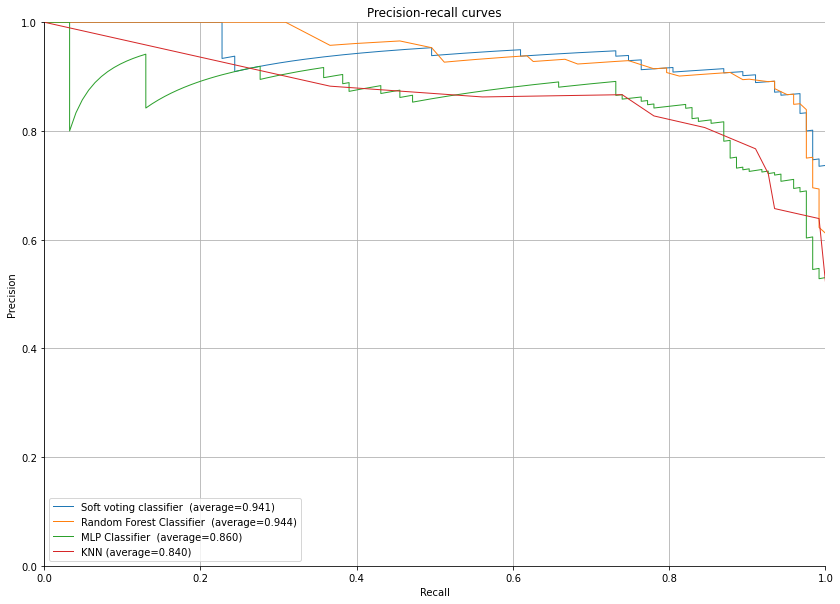

In [135]:
def precision_recall_plot(y_true, y_proba, label=' ', l='-', lw=1.0):
    from sklearn.metrics import precision_recall_curve, average_precision_score
    precision, recall, _ = precision_recall_curve(y_test,
                                                  y_proba[:,1])
    average_precision = average_precision_score(y_test, y_proba[:,1],
                                                     average="micro")
    ax.plot(recall, precision, label='%s (average=%.3f)'%(label,average_precision),
            linestyle=l, linewidth=lw)

f, ax = plt.subplots(figsize=(14,10))
precision_recall_plot(y_test,eclf1.predict_proba(X_test),label='Soft voting classifier ',l='-')
precision_recall_plot(y_test,rf_ent.predict_proba(X_test),label='Random Forest Classifier ',l='-')
precision_recall_plot(y_test,mlp.predict_proba(X_test),label='MLP Classifier ',l='-')
precision_recall_plot(y_test,knn.predict_proba(X_test),label='KNN',l='-')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.legend(loc="lower left")
ax.grid(True)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_title('Precision-recall curves')
sns.despine()

## Feature Importance

<AxesSubplot:>

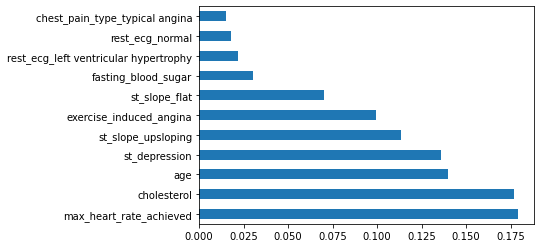

In [136]:
feat_importances = pd.Series(rf_ent.feature_importances_, index=X_train.columns)
feat_importances.nlargest(20).plot(kind='barh')